# EDA Notebook for Olist-Ecommerce Dataset on Kaggle

#### The dataset was processed with GCP and BigQuery, so...

## Imports and BigQuery Connection

In [1]:
from google.cloud import bigquery

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
# BigQuery client
keyfile_path = r"C:\Users\Ardahan\Documents\Ardahan\Data Science\Shopify Training\Day 4\jaffle-shop-483118-e1002e7d0520.json"

client = bigquery.Client.from_service_account_json(keyfile_path)

In [3]:
# Query helper function
def query_to_df(query):
    """Execute BigQuery query and return pandas DataFrame"""
    return client.query(query).to_dataframe()

In [4]:
# connection test
test = query_to_df("""
    SELECT COUNT(*) as total_orders 
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders`
""")
print(f"✓ Connection successful! Total orders: {test['total_orders'].iloc[0]:,}")


✓ Connection successful! Total orders: 99,441


In [5]:
import sys
print(sys.executable)

D:\envs\olist_analysis\python.exe


## Table and Data Overview

In [6]:
# Get table row counts
tables = {
    'orders': 'stg_olist__orders',
    'customers': 'stg_olist__customers',
    'sellers': 'stg_olist__sellers',
    'order_items': 'stg_olist__order_items',
    'products': 'stg_olist__products',
    'reviews': 'stg_olist__reviews',
    'payments': 'stg_olist__order_payments'
}

for name, table in tables.items():
    count = client.query(f"SELECT COUNT(*) as cnt FROM `jaffle-shop-483118.olist_dev.{table}`").to_dataframe()
    print(f"{name:15} {count['cnt'].iloc[0]:>10,} rows")

orders              99,441 rows
customers           99,441 rows
sellers              3,095 rows
order_items        112,650 rows
products            32,951 rows
reviews             99,224 rows
payments           103,886 rows


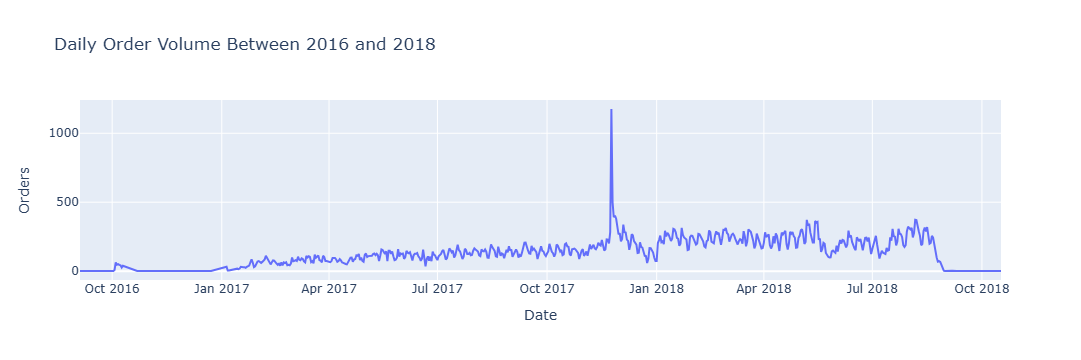

In [7]:
# Daily orders over time
orders_timeline = client.query("""
    SELECT 
        DATE(ordered_at) as order_date,
        COUNT(*) as num_orders
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders`
    GROUP BY order_date
    ORDER BY order_date
""").to_dataframe()

fig = px.line(orders_timeline, 
              x='order_date', 
              y='num_orders',
              title='Daily Order Volume Between 2016 and 2018',
              labels={'num_orders': 'Orders', 'order_date': 'Date'})
fig.show()

#### Black Friday 2017 shows a big spike in orders. Other than that, there is a clear weekly pattern, where weekends seem to have less order volume. There is also a gradual increase in daily order volume. Data appears incomplete for 2016 and post-September 2018.

### Let's focus on the complete data, which I assume is in the period with zig-zags and no constant 1 order/day pattern. From that data, let's make some observations.

### How does number of orders change weekly? 

In [19]:
# Analyze only complete data period (Jan 2017 - Aug 2018)
complete_data = client.query("""
    SELECT 
        DATE(ordered_at) as order_date,
        COUNT(*) as num_orders,
        EXTRACT(DAYOFWEEK FROM ordered_at) as day_of_week
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders`
    WHERE DATE(ordered_at) BETWEEN '2017-01-01' AND '2018-08-31'
    GROUP BY order_date, day_of_week
    ORDER BY order_date
""").to_dataframe()

# Weekday vs Weekend orders
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
             5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
complete_data['day_name'] = complete_data['day_of_week'].map(day_names)

weekday_summary = complete_data.groupby('day_name')['num_orders'].agg(['mean', 'median']).round(0)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_summary_sorted = weekday_summary.reindex(day_order)

avg_orders = weekday_summary_sorted['mean'].mean()

# Simple binary coloring
colors = ['green' if val > avg_orders else 'red' 
          for val in weekday_summary_sorted['mean']]

fig = go.Figure()

fig.add_trace(go.Bar(
    y=weekday_summary_sorted.index,  # Y-axis for horizontal
    x=weekday_summary_sorted['mean'],  # X-axis for horizontal
    orientation='h',  # Horizontal bars
    marker_color=colors,
    text=weekday_summary_sorted['mean'].astype(int),
    textposition='outside'
))

# Add average line (vertical for horizontal chart)
fig.add_vline(x=avg_orders, 
              line_dash="dash", 
              line_color="black",
              annotation_text=f"Average: {avg_orders:.0f}")

fig.update_layout(
    title=Weekday: "How Does Order Volume Change by Day of Week?,
    yaxis_title="Day of Week",
    xaxis_title="Average Orders per Day",
    showlegend=False
)

fig.show()


SyntaxError: unterminated string literal (detected at line 46) (492706105.py, line 46)

#### Seems like people on the platform like to spend their time on other activities in the weekend. What we found on the daily order volume chart is verified. 

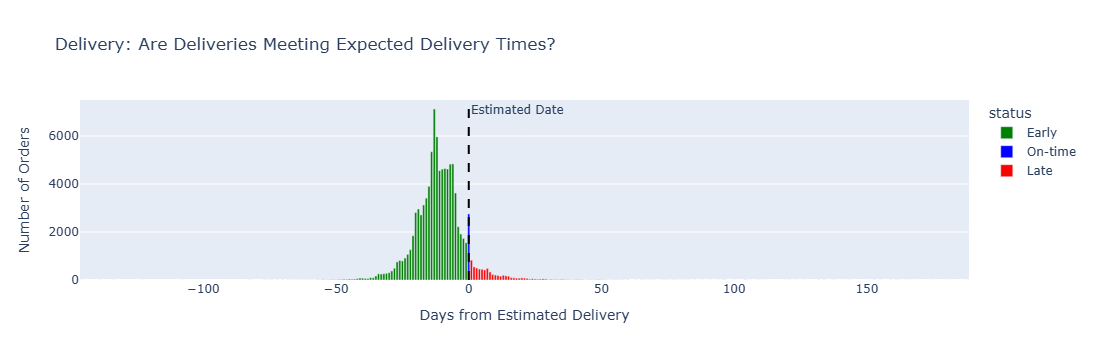

In [20]:
# Delivery delay analysis
delivery_perf = client.query("""
    SELECT 
        DATE_DIFF(delivered_to_customer_at, estimated_delivery_at, DAY) as delivery_delay_days,
        COUNT(*) as num_orders
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders`
    WHERE order_status = 'delivered'
        AND delivered_to_customer_at IS NOT NULL
        AND estimated_delivery_at IS NOT NULL
    GROUP BY delivery_delay_days
    ORDER BY delivery_delay_days
""").to_dataframe()

# conditional formatting
delivery_perf['status'] = delivery_perf['delivery_delay_days'].apply(
    lambda x: 'Early' if x < 0 else 'Late' if x > 0 else 'On-time'
)

fig = px.bar(delivery_perf, 
             x='delivery_delay_days', 
             y='num_orders',
             color='status',
             color_discrete_map={'Early': 'green', 'On-time': 'blue', 'Late': 'red'},
             title='Delivery: Are Deliveries Meeting Expected Delivery Times?',
             labels={'delivery_delay_days': 'Days from Estimated Delivery',
                    'num_orders': 'Number of Orders'})
fig.add_vline(x=0, line_dash="dash", line_color="black", 
              annotation_text="Estimated Date")
fig.show()

#### Seems like most orders miss the expected delivery date, the platform should either fasten the delivery, or make the delivery estimates better.

In [10]:
# Analysis: Do late deliveries reduce repeat purchases?
delivery_impact = client.query("""
WITH order_delivery AS (
    SELECT 
        o.order_id,
        c.customer_unique_id,
        o.ordered_at,
        o.delivered_to_customer_at,
        o.estimated_delivery_at,
        DATE_DIFF(o.delivered_to_customer_at, o.estimated_delivery_at, DAY) as delivery_delay_days,
        CASE 
            WHEN DATE_DIFF(o.delivered_to_customer_at, o.estimated_delivery_at, DAY) > 3 THEN 'Delayed (>3 days)'
            ELSE 'On-time or Minor Delay'
        END as delivery_category
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders` o
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__customers` c 
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
        AND o.delivered_to_customer_at IS NOT NULL
        AND o.estimated_delivery_at IS NOT NULL
),

customer_orders AS (
    SELECT 
        customer_unique_id,
        delivery_category,
        COUNT(*) as total_orders,
        COUNTIF(
            EXISTS(
                SELECT 1 
                FROM `jaffle-shop-483118.olist_dev.stg_olist__orders` o2
                JOIN `jaffle-shop-483118.olist_dev.stg_olist__customers` c2 
                    ON o2.customer_id = c2.customer_id
                WHERE c2.customer_unique_id = order_delivery.customer_unique_id
                    AND o2.ordered_at > order_delivery.ordered_at
            )
        ) as became_repeat_customer
    FROM order_delivery
    GROUP BY customer_unique_id, delivery_category
)

SELECT 
    delivery_category,
    COUNT(DISTINCT customer_unique_id) as total_customers,
    SUM(became_repeat_customer) as repeat_customers,
    ROUND(100.0 * SUM(became_repeat_customer) / COUNT(DISTINCT customer_unique_id), 1) as repeat_rate
FROM customer_orders
GROUP BY delivery_category
ORDER BY delivery_category
""").to_dataframe()

print(delivery_impact)


        delivery_category  total_customers  repeat_customers  repeat_rate
0       Delayed (>3 days)             4640               121          2.6
1  On-time or Minor Delay            88913              2827          3.2


In [11]:
# FIXED: Proper JOINs without IN subquery
delivery_impact_v2 = client.query("""
WITH first_orders AS (
    -- Get each customer's FIRST order
    SELECT 
        c.customer_unique_id,
        o.order_id,
        o.ordered_at as first_order_date,
        DATE_DIFF(o.delivered_to_customer_at, o.estimated_delivery_at, DAY) as delivery_delay_days,
        CASE 
            WHEN DATE_DIFF(o.delivered_to_customer_at, o.estimated_delivery_at, DAY) > 3 THEN 'Delayed (>3 days)'
            ELSE 'On-time or Minor Delay'
        END as delivery_category,
        ROW_NUMBER() OVER (PARTITION BY c.customer_unique_id ORDER BY o.ordered_at) as order_number
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders` o
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__customers` c 
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
        AND o.delivered_to_customer_at IS NOT NULL
        AND o.estimated_delivery_at IS NOT NULL
        AND DATE(o.ordered_at) < '2018-06-01'  -- Only customers with time to reorder
),

first_time_customers AS ( 
    SELECT * FROM first_orders WHERE order_number = 1
),

repeat_orders AS (
    -- Find subsequent orders for each first-time customer
    SELECT 
        ftc.customer_unique_id,
        ftc.delivery_category,
        o2.order_id as subsequent_order
    FROM first_time_customers ftc
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__customers` c2
        ON ftc.customer_unique_id = c2.customer_unique_id
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__orders` o2
        ON c2.customer_id = o2.customer_id
    WHERE o2.ordered_at > ftc.first_order_date
)

SELECT 
    ftc.delivery_category,
    COUNT(DISTINCT ftc.customer_unique_id) as total_first_time_customers,
    COUNT(DISTINCT ro.customer_unique_id) as customers_who_returned,
    ROUND(100.0 * COUNT(DISTINCT ro.customer_unique_id) / COUNT(DISTINCT ftc.customer_unique_id), 1) as repeat_purchase_rate
FROM first_time_customers ftc
LEFT JOIN repeat_orders ro
    ON ftc.customer_unique_id = ro.customer_unique_id
GROUP BY ftc.delivery_category
ORDER BY ftc.delivery_category
""").to_dataframe()

print("\n=== FIRST-TIME CUSTOMER REPEAT BEHAVIOR ===")
print(delivery_impact_v2)

# Calculate the drop
if len(delivery_impact_v2) == 2:
    on_time_rate = delivery_impact_v2[delivery_impact_v2['delivery_category'] == 'On-time or Minor Delay']['repeat_purchase_rate'].values[0]
    delayed_rate = delivery_impact_v2[delivery_impact_v2['delivery_category'] == 'Delayed (>3 days)']['repeat_purchase_rate'].values[0]
    
    drop_pct = round(100 * (on_time_rate - delayed_rate) / on_time_rate, 1)
    
    print(f"\n📊 KEY INSIGHT:")
    print(f"On-time delivery: {on_time_rate}% repeat rate")
    print(f"Delayed delivery: {delayed_rate}% repeat rate")
    print(f"Impact: {drop_pct}% DROP in repeat purchases for delayed deliveries")


=== FIRST-TIME CUSTOMER REPEAT BEHAVIOR ===
        delivery_category  total_first_time_customers  customers_who_returned  \
0       Delayed (>3 days)                        4167                     105   
1  On-time or Minor Delay                       71218                    2352   

   repeat_purchase_rate  
0                   2.5  
1                   3.3  

📊 KEY INSIGHT:
On-time delivery: 3.3% repeat rate
Delayed delivery: 2.5% repeat rate
Impact: 24.2% DROP in repeat purchases for delayed deliveries


#### Drop is 24.2%, but is this actually a significant result? There are only 4k first time customers whose orders were delayed. 

In [12]:
# Quick significance test
from scipy import stats

delayed_success = 105  # became repeat
delayed_total = 4167
ontime_success = 2352
ontime_total = 71218

# Chi-square test
contingency_table = [[delayed_success, delayed_total - delayed_success],
                     [ontime_success, ontime_total - ontime_success]]
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print(f"P-value: {p_value}")

P-value: 0.006510689282535935


#### Turns out it was actually a very significant result. If we assumed that our finding was insignificant, or there was no effect of delayed orders on first time customers, then what we actually observe actually has a 0.65% chance of happening. 

### Where are merchants/sellers based? (Geographical Distribution)

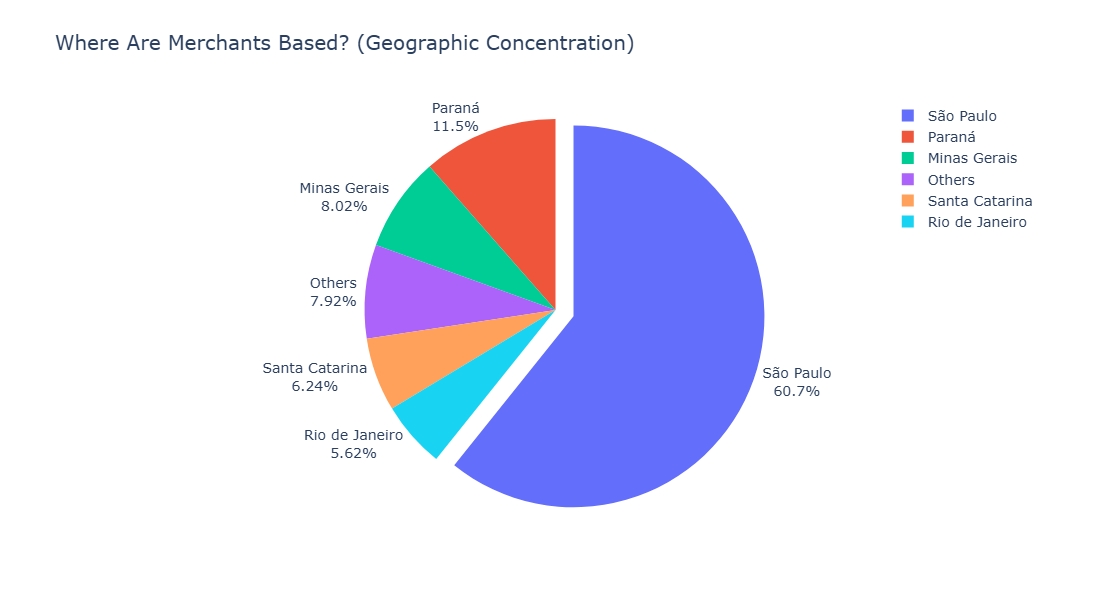


📍 São Paulo dominates: 60.7% of all sellers


In [24]:
# Where are sellers located?
seller_geo = client.query("""
    SELECT 
        s.seller_state,
        COUNT(DISTINCT s.seller_id) as num_sellers,
        COUNT(DISTINCT oi.order_id) as num_orders
    FROM `jaffle-shop-483118.olist_dev.stg_olist__sellers` s
    LEFT JOIN `jaffle-shop-483118.olist_dev.stg_olist__order_items` oi
        ON s.seller_id = oi.seller_id  -- Now qualified with table alias
    GROUP BY s.seller_state
    ORDER BY num_sellers DESC
    LIMIT 10
""").to_dataframe()

# Create "Others" category for small sellers
seller_geo_pie = seller_geo.copy()
top_n = 5  # Show top 5 states individually

# Separate top states from others
top_states = seller_geo_pie.head(top_n)
other_states = seller_geo_pie.iloc[top_n:]

# Create pie chart data
if len(other_states) > 0:
    others_row = pd.DataFrame({
        'seller_state': ['Others'],
        'num_sellers': [other_states['num_sellers'].sum()],
        'num_orders': [other_states['num_orders'].sum()]
    })
    pie_data = pd.concat([top_states, others_row], ignore_index=True)
else:
    pie_data = top_states

# Brazilian state mapping
state_names = {
    'SP': 'São Paulo', 'PR': 'Paraná', 'MG': 'Minas Gerais',
    'RJ': 'Rio de Janeiro', 'RS': 'Rio Grande do Sul',
    'SC': 'Santa Catarina', 'BA': 'Bahia', 'GO': 'Goiás',
    'ES': 'Espírito Santo', 'CE': 'Ceará', 'DF': 'Distrito Federal',
    'PE': 'Pernambuco', 'PA': 'Pará', 'MT': 'Mato Grosso', 'MA': 'Maranhão'
}

pie_data['state_full'] = pie_data['seller_state'].map(state_names).fillna(pie_data['seller_state'])

fig = px.pie(pie_data, 
             values='num_sellers', 
             names='state_full',
             title='Where Are Merchants Based? (Geographic Concentration)')

fig.update_traces(
    textposition='outside',  # Labels outside
    textinfo='label+percent',  # Show name and percentage
    pull=[0.1, 0, 0, 0, 0, 0]  # Pull out the largest slice slightly for emphasis
)

fig.update_layout(
    width=800,   # Bigger chart
    height=600,
    font=dict(size=14)  # Larger text
)

fig.show()

print(f"\n São Paulo dominates: {seller_geo.iloc[0]['num_sellers'] / seller_geo['num_sellers'].sum() * 100:.1f}% of all sellers")

In [14]:
# Check actual columns
check_cols = client.query("""
    SELECT * FROM `jaffle-shop-483118.olist_dev.stg_olist__order_items`
    LIMIT 1
""").to_dataframe()

print(check_cols.columns.tolist())

['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


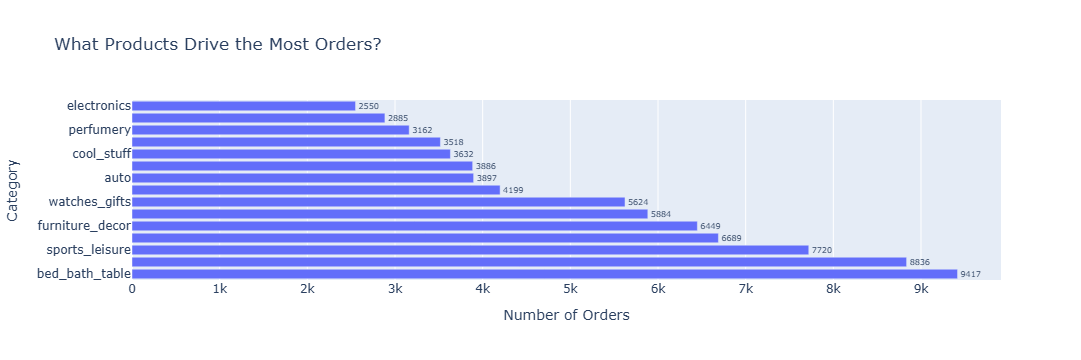

In [15]:
# What are customers buying?
top_categories = client.query("""
    SELECT 
        COALESCE(t.product_category_name_english, 'Unknown') as category,
        COUNT(DISTINCT oi.order_id) as num_orders,
        ROUND(AVG(oi.price), 2) as avg_price
    FROM `jaffle-shop-483118.olist_dev.stg_olist__order_items` oi
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__products` p
        ON oi.product_id = p.product_id
    LEFT JOIN `jaffle-shop-483118.olist_dev.stg_olist__product_category_name_translation` t
        ON p.product_category_name = t.product_category_name
    GROUP BY category
    ORDER BY num_orders DESC
    LIMIT 15
""").to_dataframe()

fig = px.bar(top_categories, 
             x='num_orders', 
             y='category',
             orientation='h',
             title='Products: What Products Drive the Most Orders?',
             labels={'num_orders': 'Number of Orders', 'category': 'Category'},
             text='num_orders')
fig.update_traces(textposition='outside')
fig.show()

#### Merchant Churn

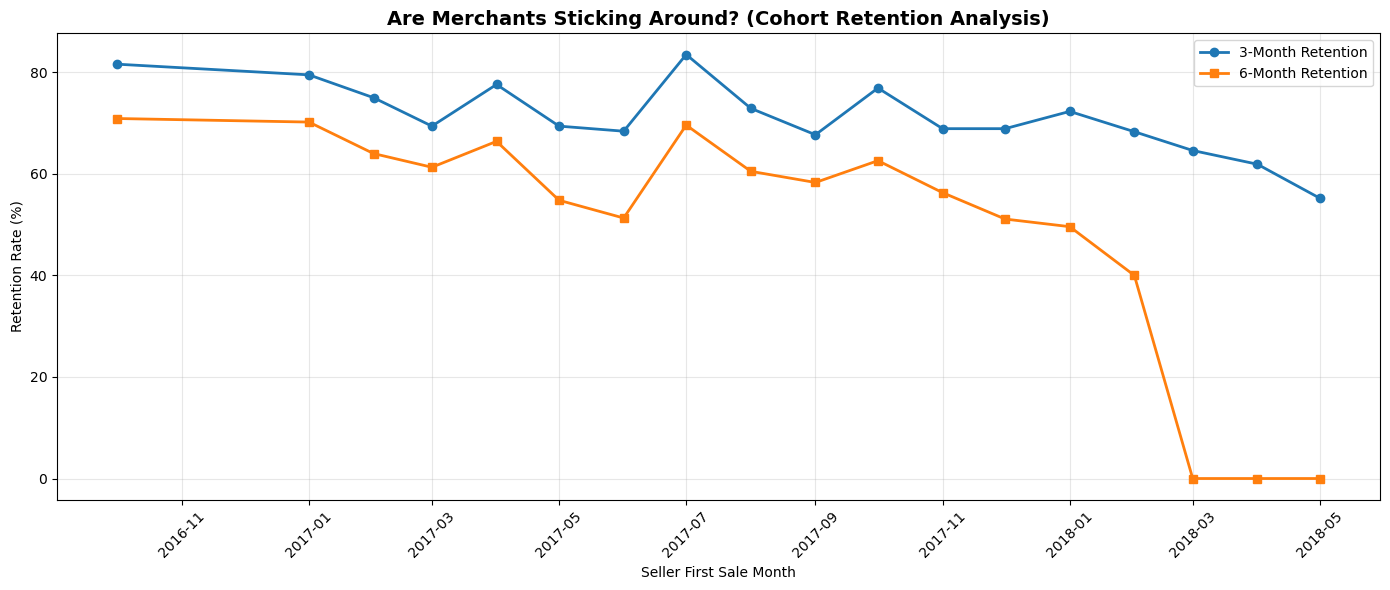


📊 Merchant Retention Metrics:
Average 3-month retention: 71.2%
Average 6-month retention: 49.3%
Implied 3-month churn rate: 28.8%
Implied 6-month churn rate: 50.7%

⚠️ Merchant churn IS a problem - less than 70% stick around after 6 months!
✅ Merchant churn mart VALIDATED and CRITICAL!


In [25]:
merchant_churn = client.query("""
WITH seller_first_sale AS (
    -- When did each seller first appear?
    SELECT 
        oi.seller_id,
        DATE_TRUNC(DATE(MIN(o.ordered_at)), MONTH) as first_sale_month
    FROM `jaffle-shop-483118.olist_dev.stg_olist__order_items` oi
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__orders` o
        ON oi.order_id = o.order_id
    WHERE DATE(o.ordered_at) < '2018-06-01'  -- Need time to track retention
    GROUP BY oi.seller_id
),

seller_activity_by_month AS (
    -- Which sellers were active each month?
    SELECT 
        oi.seller_id,
        DATE_TRUNC(DATE(o.ordered_at), MONTH) as activity_month
    FROM `jaffle-shop-483118.olist_dev.stg_olist__order_items` oi
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__orders` o
        ON oi.order_id = o.order_id
    GROUP BY oi.seller_id, activity_month
),

cohort_retention AS (
    SELECT 
        sfs.first_sale_month,
        COUNT(DISTINCT sfs.seller_id) as cohort_size,
        -- Still active 3 months later?
        COUNT(DISTINCT CASE 
            WHEN sam.activity_month >= DATE_ADD(sfs.first_sale_month, INTERVAL 3 MONTH)
            THEN sfs.seller_id 
        END) as active_after_3mo,
        -- Still active 6 months later?
        COUNT(DISTINCT CASE 
            WHEN sam.activity_month >= DATE_ADD(sfs.first_sale_month, INTERVAL 6 MONTH)
            THEN sfs.seller_id 
        END) as active_after_6mo
    FROM seller_first_sale sfs
    LEFT JOIN seller_activity_by_month sam
        ON sfs.seller_id = sam.seller_id
    GROUP BY sfs.first_sale_month
    HAVING COUNT(DISTINCT sfs.seller_id) >= 10  -- Only cohorts with 10+ sellers
)

SELECT 
    first_sale_month,
    cohort_size,
    ROUND(100.0 * active_after_3mo / cohort_size, 1) as retention_3mo_pct,
    ROUND(100.0 * active_after_6mo / cohort_size, 1) as retention_6mo_pct
FROM cohort_retention
ORDER BY first_sale_month
""").to_dataframe()

# Plot retention rates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(merchant_churn['first_sale_month'], 
        merchant_churn['retention_3mo_pct'], 
        marker='o', label='3-Month Retention', linewidth=2)
ax.plot(merchant_churn['first_sale_month'], 
        merchant_churn['retention_6mo_pct'], 
        marker='s', label='6-Month Retention', linewidth=2)

ax.set_title('Are Merchants Sticking Around? (Cohort Retention Analysis)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Retention Rate (%)')
ax.set_xlabel('Seller First Sale Month')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary stats
avg_retention_3mo = merchant_churn['retention_3mo_pct'].mean()
avg_retention_6mo = merchant_churn['retention_6mo_pct'].mean()

print(f"\n📊 Merchant Retention Metrics:")
print(f"Average 3-month retention: {avg_retention_3mo:.1f}%")
print(f"Average 6-month retention: {avg_retention_6mo:.1f}%")
print(f"Implied 3-month churn rate: {100 - avg_retention_3mo:.1f}%")
print(f"Implied 6-month churn rate: {100 - avg_retention_6mo:.1f}%")

if avg_retention_6mo < 70:
    print(f"\n Merchant churn IS a problem - less than 70% stick around after 6 months! - SHOULD analyze deeper in marts")
elif avg_retention_6mo < 85:
    print(f"\n⚠️ Moderate merchant churn - can analyze deeper in marts.")


#### Customer Cohort

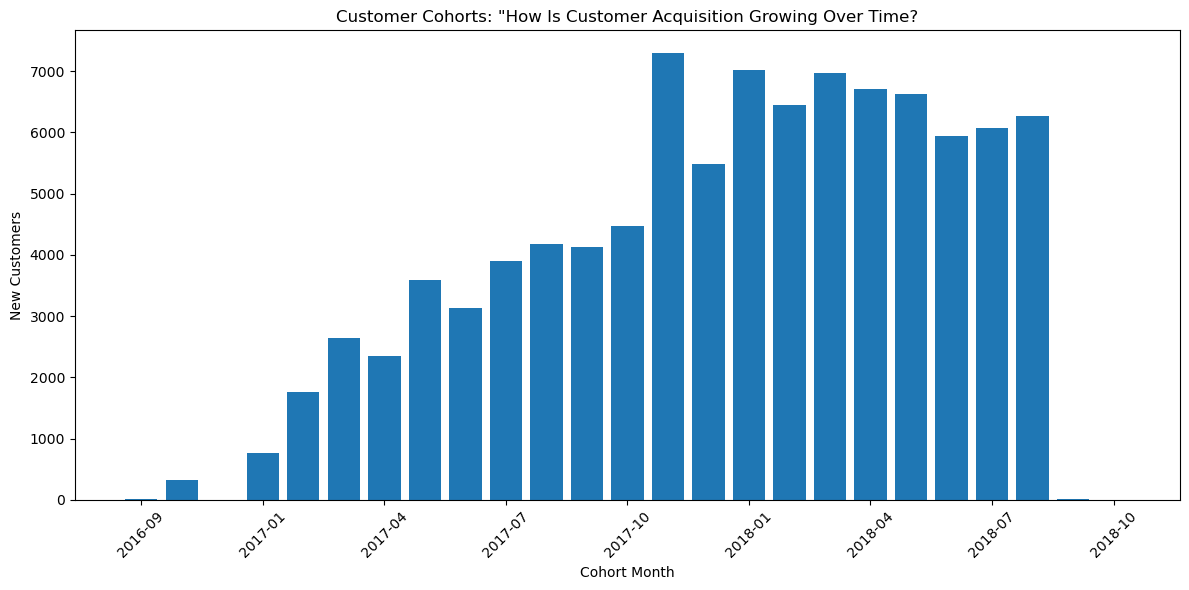


Cohorts range from 1 to 7304 customers
✅ Variation exists - cohort analysis mart validated!


In [23]:
# Cohort analysis validation
cohort_check = client.query("""
WITH first_purchase AS (
    SELECT 
        c.customer_unique_id,
        MIN(o.ordered_at) as first_order_date
    FROM `jaffle-shop-483118.olist_dev.stg_olist__orders` o
    JOIN `jaffle-shop-483118.olist_dev.stg_olist__customers` c
        ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
)

SELECT 
    DATE_TRUNC(DATE(first_order_date), MONTH) as cohort_month,
    COUNT(DISTINCT customer_unique_id) as cohort_size
FROM first_purchase
GROUP BY cohort_month
ORDER BY cohort_month
""").to_dataframe()

# Convert to datetime for plotting
cohort_check['cohort_month'] = pd.to_datetime(cohort_check['cohort_month'])

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(range(len(cohort_check)), cohort_check['cohort_size'])
plt.title('Customer Cohorts: "How Is Customer Acquisition Growing Over Time?')
plt.ylabel('New Customers')
plt.xlabel('Cohort Month')
plt.xticks(range(0, len(cohort_check), 3), 
           cohort_check['cohort_month'].iloc[::3].dt.strftime('%Y-%m'), 
           rotation=45)
plt.tight_layout()
plt.show()

print(f"\nCohorts range from {cohort_check['cohort_size'].min()} to {cohort_check['cohort_size'].max()} customers")
print("Variation exists in cohorts - can analyze deeper in marts!")

# Key Findings Summary

## Business Context
**Dataset:** Brazilian e-commerce marketplace (Olist), Sept 2016 - Aug 2018
**Scope:** 99K+ orders, 96K customers, 3K merchants

## Critical Insights

### 1. 🚨 MERCHANT CHURN CRISIS - Platform's Biggest Challenge
- **Finding:** **50.7% of new merchants churn within 6 months**
- **3-month retention:** 71.2% (implies 28.8% early churn)
- **6-month retention:** 49.3% (over half leave!)
- **Business impact:** Wasted acquisition costs, reduced marketplace density, threatens platform viability
- **Root cause investigation needed:** Why are half of merchants leaving?

### 2. Delivery Performance Drives Customer Retention ⚠️
- **Finding:** First-time customers with delayed deliveries (>3 days) show **24% lower repeat purchase rate**
- **Baseline rates:** 3.3% (on-time) vs 2.5% (delayed)
- **Statistical significance:** p < 0.01 (highly significant)
- **Business impact:** In low-retention marketplace, delivery experience is critical differentiator
- **Sample:** 75K+ first-time customers analyzed

### 3. Platform Growth Trajectory 📈
- **Merchant acquisition:** 170% growth (early: 386 → late: 1,042 active/month)
- **Customer acquisition:** 220% growth (early cohorts: ~2K → late: ~6K new customers/month)
- **Geographic concentration:** Top 3 states (SP, PR, MG) = 80% of sellers
- **Peak shopping:** Monday/Tuesday (~185 orders/day), Weekend dip (~130/day)
- **Seasonality:** Black Friday 2017 (Nov 24) - 1,176 orders (10-15x spike)

### 4. Data Quality Notes
- **Coverage:** Limited data for early 2016 and post-Sept 2018
- **Recommended analysis period:** Jan 2017 - Aug 2018 (complete data)
- **Review duplicates:** ~800 duplicate review_ids identified and documented



## Strategic Recommendations

1. **URGENT:** Investigate merchant churn root causes
   - Survey exiting merchants
   - Analyze profitability by cohort
   - Review payment terms, fees, support quality

2. **Address delivery delays systematically**
   - Merchant education on realistic estimates
   - Carrier performance monitoring
   - Customer communication improvements

3. **Retention-focused product development**
   - Both merchants and customers show low retention
   - Platform needs "stickiness" features
   - Consider loyalty programs, improved tools

## Next Steps
- Build production mart models in dbt
- Create merchant churn early warning system
- Develop retention dashboards for ops team
- Deep-dive analysis: merchant profitability vs churn correlation